# Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocess import Pool
from tqdm import tqdm

# Core Calculation: Payoffs and Stationary Distribution

In [17]:
def calc_metrics_custom(p, q, b1, b2, c, eps, rule):
    import numpy as np
    # Apply implementation error (noise) to the strategies
    p_eff = p * (1 - 2 * eps) + eps
    q_eff = q * (1 - 2 * eps) + eps
    
    M = np.zeros((8, 8))
    # Mapping for opponent's previous move indices
    opp_idx = {0: 0, 1: 2, 2: 1, 3: 3} 
    
    for s in range(8):
        env_idx = s // 4
        c1 = p_eff[s]
        c2 = q_eff[env_idx * 4 + opp_idx[s % 4]]
        # Joint probabilities: [CC, CD, DC, DD]
        probs = [c1 * c2, c1 * (1 - c2), (1 - c1) * c2, (1 - c1) * (1 - c2)]
        
        for act, prob in enumerate(probs):
            # Environment Code: 0 = Good, 1 = Bad
            if act == 0: next_env = rule[0]      # Mutual Cooperation
            elif act == 3: next_env = rule[2]    # Mutual Defection
            else: next_env = rule[1]             # Mixed (CD or DC)
            
            M[s, next_env * 4 + act] = prob

    # Calculate stationary distribution
    vals, vecs = np.linalg.eig(M.T)
    idx = np.argmin(np.abs(vals - 1.0))
    v = np.abs(vecs[:, idx].real)
    v /= v.sum()
    
    # Calculate metrics
    coop_rate = np.dot(v, p_eff)
    time_in_s1 = np.sum(v[:4]) 
    
    # Payoffs
    u1 = np.array([b1 - c, -c, b1, 0])
    u2 = np.array([b2 - c, -c, b2, 0])
    pi_p = np.dot(v[:4], u1) + np.dot(v[4:], u2)
    
    u1_m = np.array([b1 - c, b1, -c, 0])
    u2_m = np.array([b2 - c, b2, -c, 0])
    pi_q = np.dot(v[:4], u1_m) + np.dot(v[4:], u2_m)
    
    return pi_p, pi_q, coop_rate, time_in_s1

In [18]:
def get_fixation_probability(pi_m, pi_r, pi_mm, pi_rm, n_pop, beta):
    diffs = []
    for j in range(1, n_pop):
        f_m = ((j - 1) * pi_mm + (n_pop - j) * pi_m) / (n_pop - 1)
        f_r = (j * pi_rm + (n_pop - j - 1) * pi_r) / (n_pop - 1)
        diffs.append(f_r - f_m)
    
    exponent_sums = np.cumsum(beta * np.array(diffs))
    return 1.0 / (1.0 + np.sum(np.exp(np.clip(exponent_sums, -200, 200))))

In [21]:
def run_simulation_full(args):
    import numpy as np
    
    def _calc_metrics_internal(p, q, b1, b2, c, eps, rule):
        p_eff = p * (1 - 2 * eps) + eps
        q_eff = q * (1 - 2 * eps) + eps
        M = np.zeros((8, 8))
        opp_idx = {0: 0, 1: 2, 2: 1, 3: 3} 
        for s in range(8):
            env_idx = s // 4
            c1, c2 = p_eff[s], q_eff[env_idx * 4 + opp_idx[s % 4]]
            probs = [c1 * c2, c1 * (1 - c2), (1 - c1) * c2, (1 - c1) * (1 - c2)]
            for act, prob in enumerate(probs):
                if act == 0: next_env = rule[0]
                elif act == 3: next_env = rule[2]
                else: next_env = rule[1]
                M[s, next_env * 4 + act] = prob
        vals, vecs = np.linalg.eig(M.T)
        idx = np.argmin(np.abs(vals - 1.0))
        v = np.abs(vecs[:, idx].real)
        v /= v.sum()
        u1, u2 = np.array([b1-c, -c, b1, 0]), np.array([b2-c, -c, b2, 0])
        pi_p = np.dot(v[:4], u1) + np.dot(v[4:], u2)
        return pi_p, 0, np.dot(v, p_eff), np.sum(v[:4])

    def _get_fixation_internal(pi_m, pi_r, pi_mm, pi_rm, n_pop, beta):
        diffs = []
        for j in range(1, n_pop):
            f_m = ((j - 1) * pi_mm + (n_pop - j) * pi_m) / (n_pop - 1)
            f_r = (j * pi_rm + (n_pop - j - 1) * pi_r) / (n_pop - 1)
            diffs.append(f_r - f_m)
        exponent_sums = np.cumsum(beta * np.array(diffs))
        return 1.0 / (1.0 + np.sum(np.exp(np.clip(exponent_sums, -200, 200))))

    # --- Début de la simulation ---
    idx, label, code_rule = args
    b1, b2, c, beta, eps, N, steps = 2.0, 1.2, 1.0, 100, 0.001, 100, 5000
    res_strat = np.zeros(8)
    steady_start = int(steps * 0.5)
    avg_coop, avg_time_s1 = 0.0, 0.0
    
    for t in range(steps):
        mut_strat = np.random.randint(0, 2, 8).astype(np.float64)
        
        pi_rr, _, _, _ = _calc_metrics_internal(res_strat, res_strat, b1, b2, c, eps, code_rule)
        pi_rm, pi_mr, _, _ = _calc_metrics_internal(res_strat, mut_strat, b1, b2, c, eps, code_rule)
        pi_mm, _, _, _ = _calc_metrics_internal(mut_strat, mut_strat, b1, b2, c, eps, code_rule)
        
        p_fix = _get_fixation_internal(pi_mr, pi_rr, pi_mm, pi_rm, N, beta)
        
        if np.random.rand() < p_fix:
            res_strat = mut_strat
            
        if t >= steady_start:
            _, _, c_r, t_s1 = _calc_metrics_internal(res_strat, res_strat, b1, b2, c, eps, code_rule)
            avg_coop += c_r
            avg_time_s1 += t_s1
            
    count = steps - steady_start
    return idx, avg_coop / count, avg_time_s1 / count

Starting 800 simulation runs...



100%|█████████████████████████████████████████████████████████████| 800/800 [36:11<00:00,  2.71s/it]
Exception ignored in: <function tqdm.__del__ at 0x00000189776E40D8>
Traceback (most recent call last):
  File "c:\users\souha\learndy\venv\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\users\souha\learndy\venv\lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


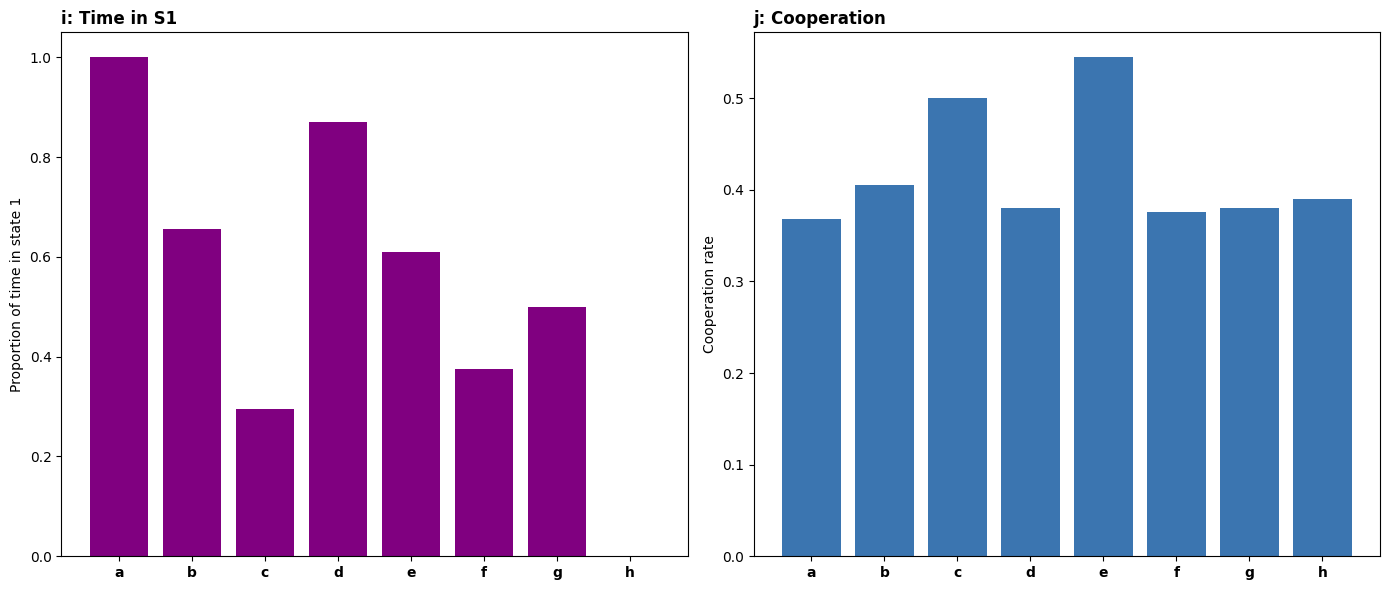

In [22]:
# Setup rules
ordered_rules = [
    ('a', [1, 1, 1]), ('b', [1, 1, 0]), ('c', [1, 0, 0]), ('d', [0, 1, 1]),
    ('e', [1, 0, 1]), ('f', [0, 0, 1]), ('g', [0, 1, 0]), ('h', [0, 0, 0]),
]

RUNS = 100 
tasks = []
for idx, (label, paper_rule) in enumerate(ordered_rules):
    code_rule = [1 - x for x in paper_rule]
    for _ in range(RUNS):
        tasks.append((idx, label, code_rule))

# Parallel Execution
print(f"Starting {len(tasks)} simulation runs...")
with Pool() as pool:
    results = list(tqdm(pool.imap(run_simulation_full, tasks), total=len(tasks)))

# Post-processing
coop_data, time_s1_data, counts = np.zeros(8), np.zeros(8), np.zeros(8)
for idx, c_r, t_s1 in results:
    coop_data[idx] += c_r
    time_s1_data[idx] += t_s1
    counts[idx] += 1
    
coop_data /= counts
time_s1_data /= counts

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
x = range(8)
labels = [r[0] for r in ordered_rules]

ax1.bar(x, time_s1_data, color='#800080')
ax1.set_xticks(x); ax1.set_xticklabels(labels, fontweight='bold')
ax1.set_ylabel('Proportion of time in state 1')
ax1.set_title('i: Time in S1', loc='left', fontweight='bold')

ax2.bar(x, coop_data, color='#3b75b0')
ax2.set_xticks(x); ax2.set_xticklabels(labels, fontweight='bold')
ax2.set_ylabel('Cooperation rate')
ax2.set_title('j: Cooperation', loc='left', fontweight='bold')

plt.tight_layout()
plt.show()